In [1]:
from tensorflow import keras
from keras.layers import Conv2D, MaxPooling2D, Concatenate, Input, BatchNormalization, Activation, Add, GlobalAveragePooling2D, Dense

In [ ]:
train_path = 'E:/Final Year Project/Cancer_dataset_all/train'
test_path = 'E:/Final Year Project/Cancer_dataset_all/test'
val_path = 'E:/Final Year Project/Cancer_dataset_all/val'

train_ds = keras.utils.image_dataset_from_directory(
    train_path,
    batch_size=32,
    image_size=(72,72),
    shuffle=True
)
val_ds = keras.utils.image_dataset_from_directory(
    val_path,
    batch_size=32,
    image_size=(72,72),
    shuffle=True
)

Found 104000 files belonging to 26 classes.
Found 13000 files belonging to 26 classes.


In [3]:
def inception_block(input_tensor, filters_1x1, filters_3x3_reduce, filters_3x3, filters_5x5_reduce, filters_5x5, filters_pool_proj):
    """
    Creates an Inception block with the following structure:
    - 1x1 Convolution
    - 1x1 Convolution followed by 3x3 Convolution
    - 1x1 Convolution followed by 5x5 Convolution
    - 3x3 MaxPooling followed by 1x1 Convolution
    All outputs are concatenated along the channel dimension.

    Args:
    input_tensor: Input tensor.
    filters_1x1: Number of filters for the 1x1 convolution.
    filters_3x3_reduce: Number of filters for the 1x1 convolution before the 3x3 convolution.
    filters_3x3: Number of filters for the 3x3 convolution.
    filters_5x5_reduce: Number of filters for the 1x1 convolution before the 5x5 convolution.
    filters_5x5: Number of filters for the 5x5 convolution.
    filters_pool_proj: Number of filters for the 1x1 convolution after the max pooling.

    Returns:
    Output tensor after applying the Inception block.
    """
    
    # 1x1 Convolution branch
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(input_tensor)
    
    # 1x1 Convolution followed by 3x3 Convolution branch
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(input_tensor)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu')(conv_3x3)
    
    # 1x1 Convolution followed by 5x5 Convolution branch
    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(input_tensor)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu')(conv_5x5)
    
    # 3x3 MaxPooling followed by 1x1 Convolution branch
    pool_proj = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(input_tensor)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu')(pool_proj)
    
    # Concatenate all the branches
    output = Concatenate(axis=-1)([conv_1x1, conv_3x3, conv_5x5, pool_proj])
    
    return output

In [5]:
def residual_block(input_tensor, filters, kernel_size=3, stride=1, use_projection=False):
    """
    Creates a Residual Block with the following structure:
    - (Optional) 1x1 Convolution for projection (to match dimensions if needed)
    - 2x (Convolution -> BatchNorm -> ReLU)
    - Add shortcut connection to the input
    
    Args:
    input_tensor: Input tensor.
    filters: Number of filters for the convolutional layers.
    kernel_size: Size of the convolution kernel.
    stride: Stride of the first convolution. Usually 1, but can be set to 2 for downsampling.
    use_projection: If True, a 1x1 convolution is used on the shortcut path to match dimensions.
    
    Returns:
    Output tensor after applying the Residual Block.
    """
    
    # Shortcut connection (identity)
    shortcut = input_tensor

    # First Convolution layer
    x = Conv2D(filters, kernel_size, strides=stride, padding='same', use_bias=False)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Second Convolution layer
    x = Conv2D(filters, kernel_size, strides=1, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    
    # If use_projection is True, apply a 1x1 convolution to match dimensions
    if use_projection:
        shortcut = Conv2D(filters, (1, 1), strides=stride, padding='same', use_bias=False)(input_tensor)
        shortcut = BatchNormalization()(shortcut)
    
    # Add the shortcut to the output
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    
    return x


In [6]:
def hybrid_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    x = prev = Conv2D(64, (1, 1), padding='same', activation='relu')(inputs)
    
    x1 = residual_block(x, filters=64, stride=1, use_projection=False)
    x2 = inception_block(x, filters_1x1=16, filters_3x3_reduce=16, filters_3x3=16, filters_5x5_reduce=8, filters_5x5=16, filters_pool_proj=16)
    x = Add()([x1, x2])
    
    x = prev = Add()([prev, x])
    
    
    
    x1 = residual_block(x, filters=128, stride=1, use_projection=True)
    x2 = inception_block(x, filters_1x1=32, filters_3x3_reduce=32, filters_3x3=32, filters_5x5_reduce=16, filters_5x5=32, filters_pool_proj=32)
    x = Add()([x1, x2])
    
    prev = Conv2D(128, (1, 1), padding='same', activation='relu')(prev)
    x = prev = Add()([prev, x])
    
    x1 = residual_block(x, filters=256, stride=1, use_projection=True)
    x2 = inception_block(x, filters_1x1=64, filters_3x3_reduce=64, filters_3x3=64, filters_5x5_reduce=16, filters_5x5=64, filters_pool_proj=64)
    x = Add()([x1, x2])
    
    prev = Conv2D(256, (1, 1), padding='same', activation='relu')(prev)
    x = prev = Add()([prev, x])
    
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = keras.Model(inputs, outputs)
    
    return model

model = hybrid_model((72, 72, 3), 26)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 72, 72, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 72, 72, 64)   256         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 72, 72, 64)   36864       ['conv2d[0][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 72, 72, 64)  256         ['conv2d_1[0][0]']               
 alization)                                                                                   

In [7]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [8]:
history = model.fit(train_ds, epochs=10, batch_size=32, validation_data=val_ds)

Epoch 1/10
3250/3250 [==============================] - 911s 269ms/step - loss: 1.2019 - accuracy: 0.7180 - val_loss: 0.4894 - val_accuracy: 0.8105
Epoch 2/10
3250/3250 [==============================] - 859s 264ms/step - loss: 0.3721 - accuracy: 0.8572 - val_loss: 0.2997 - val_accuracy: 0.8773
Epoch 3/10
3250/3250 [==============================] - 855s 263ms/step - loss: 0.2652 - accuracy: 0.8972 - val_loss: 0.3662 - val_accuracy: 0.8618
Epoch 4/10
3250/3250 [==============================] - 857s 264ms/step - loss: 0.2070 - accuracy: 0.9206 - val_loss: 0.2451 - val_accuracy: 0.9060
Epoch 5/10
3250/3250 [==============================] - 853s 263ms/step - loss: 0.1678 - accuracy: 0.9351 - val_loss: 0.1587 - val_accuracy: 0.9413
Epoch 6/10
3250/3250 [==============================] - 857s 264ms/step - loss: 0.1426 - accuracy: 0.9453 - val_loss: 0.1059 - val_accuracy: 0.9595
Epoch 7/10
3250/3250 [==============================] - 858s 264ms/step - loss: 0.1224 - accuracy: 0.9530 - val_

In [10]:
model.save('incep-res__26class_2dec2024.h5')

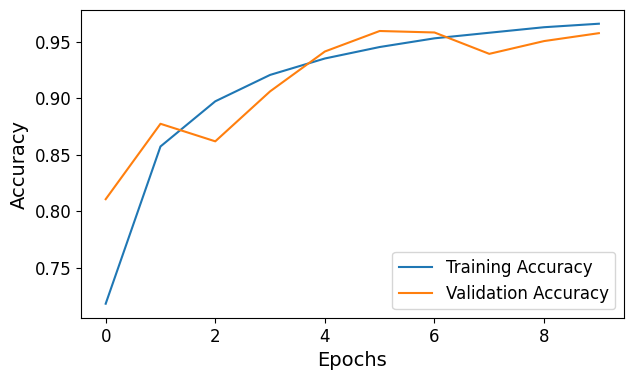

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sn

plt.figure(figsize=(7,4))
sn.lineplot(x=range(10), y=history.history['accuracy'], label='Training Accuracy')
sn.lineplot(x=range(10), y=history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.show()

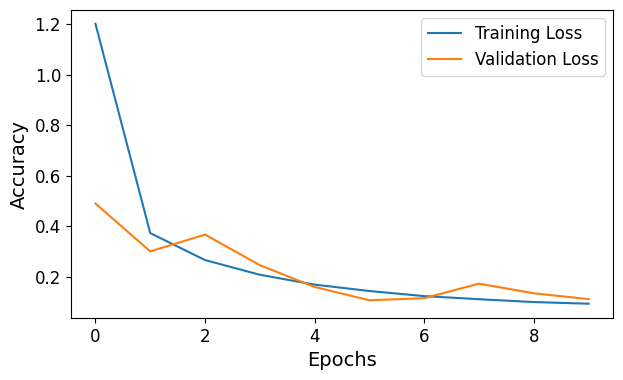

In [ ]:
plt.figure(figsize=(7,4))
sn.lineplot(x=range(10), y=history.history['loss'], label='Training Loss')
sn.lineplot(x=range(10), y=history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.show()

In [ ]:
test_ds = keras.utils.image_dataset_from_directory(
    test_path,
    batch_size=32,
    image_size=(72,72),
    shuffle=False
)

Found 13000 files belonging to 26 classes.


In [13]:
model.evaluate(test_ds)

407/407 [==============================] - 39s 94ms/step - loss: 0.1152 - accuracy: 0.9582


[0.11521929502487183, 0.9581538438796997]

In [5]:
import numpy as np

In [2]:
model = keras.models.load_model('Incep-Res Models/incep-res__26class_2dec2024.h5')

In [4]:
test_path = 'E:/Final Year Project/Cancer_dataset_all/test'
test_ds = keras.utils.image_dataset_from_directory(
    test_path,
    batch_size=32,
    image_size=(72,72),
    shuffle=False
)

Found 13000 files belonging to 26 classes.


In [16]:
lab = np.asarray([], dtype=int)
pred = np.asarray([], dtype=int)
for i, l in test_ds:
    lab = np.concatenate((lab, l), axis=-1)
    pred = np.concatenate((pred, np.argmax(model.predict(i), axis=-1)))
lab

1/1 [==============================] - 0s 15ms/step


array([ 0,  0,  0, ..., 25, 25, 25])

In [15]:
pred.shape

(13000,)

In [17]:
cm = np.zeros((26,26), dtype=int)
for i in range(len(pred)):
    cm[pred[i]][lab[i]] += 1

In [18]:
cm

array([[424,   0,   2,   2,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [ 69, 499,  10,   2,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0, 487,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0, 491,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0, 449,   4,   3,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,  49, 493, 101,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   2,   3, 396,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   

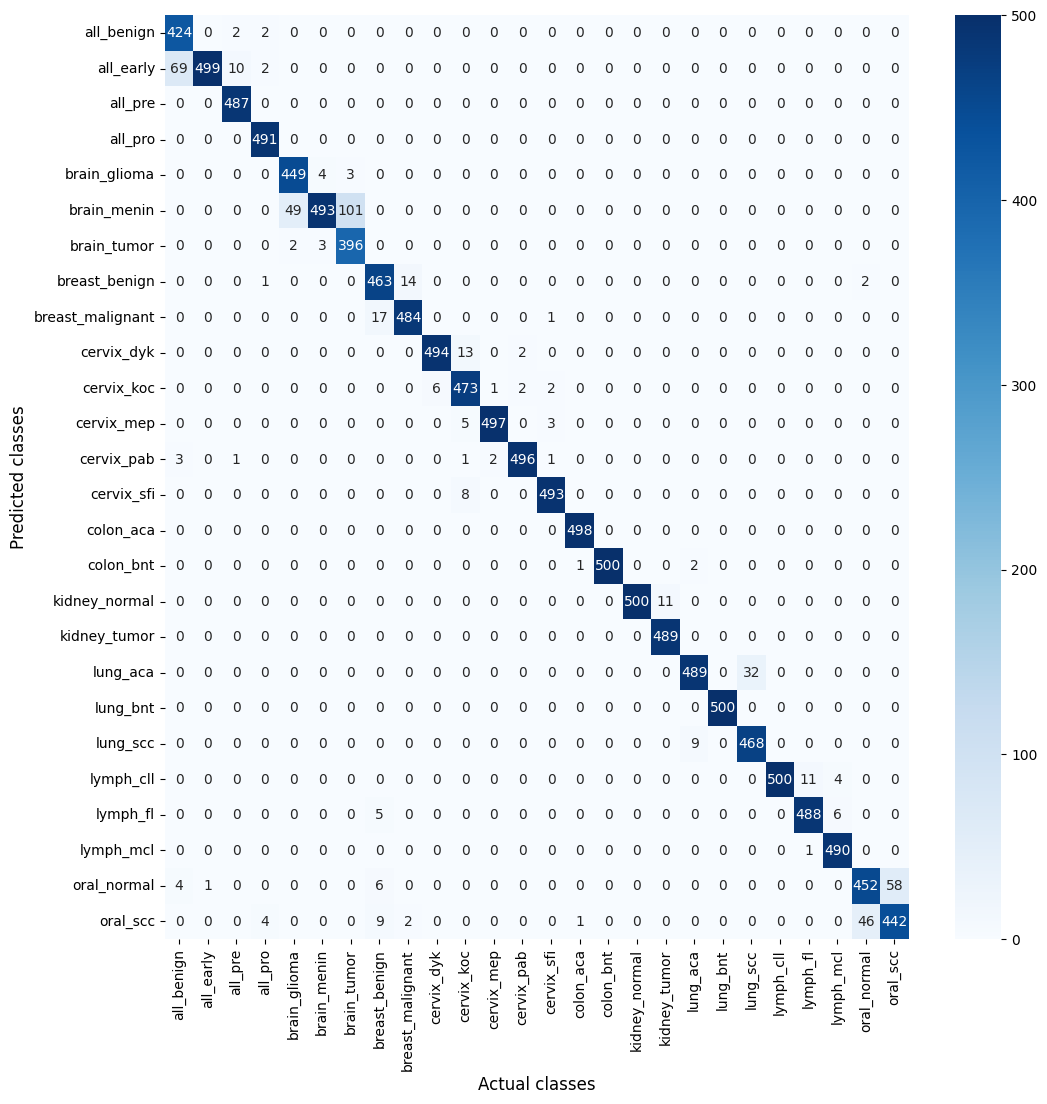

In [22]:
import matplotlib.pyplot as plt
import seaborn as sn


plt.figure(figsize=(12, 12))
# sn.heatmap(cm, cmap='Blues', xticklabels=test_ds.class_names, yticklabels=test_ds.class_names, annot=True, fmt='d', linewidths=0.1, linecolor='white')
sn.heatmap(cm, cmap='Blues', xticklabels=test_ds.class_names, yticklabels=test_ds.class_names, annot=True, fmt='d')
plt.xlabel('Actual classes',fontsize=12)
plt.ylabel('Predicted classes',fontsize=12)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
plt.show()

In [23]:
dt = {
    'ALL': [0,1,2,3],
    'Brain': [4,5,6],
    'Breast': [7,8],
    'Cervical': [9,10,11,12,13],
    'Kidney': [14,15],
    'Lung and Colon': [16,17,18,19,20],
    'Lymphoma': [21,22,23],
    'Oral': [24,25]
}

In [24]:
cm_8x8 = np.zeros((8, 8), dtype=int)
group_to_index = {}
current_index = 0
for group_name, indices in dt.items():
    group_to_index[group_name] = current_index
    current_index += 1

def find_group_by_index(index):
    for group_name, indices in dt.items():
        if index in indices:
            return group_name
    return None
for i in range(56):
    for j in range(56):
        group_i = find_group_by_index(i)
        group_j = find_group_by_index(j)
        if group_i is not None and group_j is not None:
            new_i = group_to_index[group_i]
            new_j = group_to_index[group_j]
            cm_8x8[new_i, new_j] += cm[i, j]

#Final soln
print(cm_8x8)

[[1986    0    0    0    0    0    0    0]
 [   0 1500    0    0    0    0    0    0]
 [   1    0  978    1    0    0    0    2]
 [   4    0    0 2499    0    0    0    0]
 [   0    0    0    0  999    2    0    0]
 [   0    0    0    0    0 2498    0    0]
 [   0    0    5    0    0    0 1500    0]
 [   9    0   17    0    1    0    0  998]]


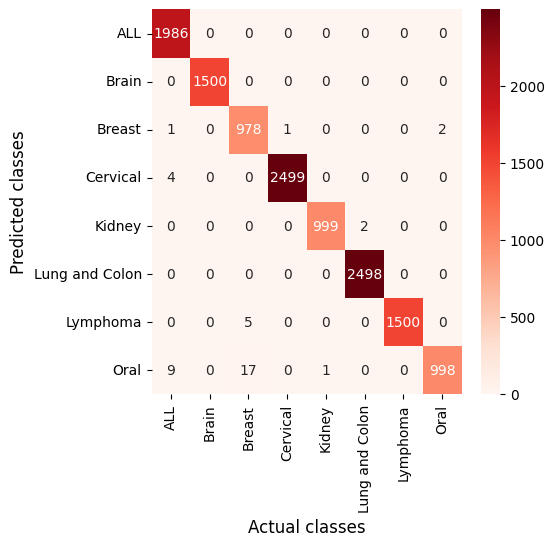

In [28]:
plt.figure(figsize=(5, 5))
# sn.heatmap(cm, cmap='Blues', xticklabels=test_ds.class_names, yticklabels=test_ds.class_names, annot=True, fmt='d', linewidths=0.1, linecolor='white')
sn.heatmap(cm_8x8, cmap='Reds', xticklabels=dt.keys(), yticklabels=dt.keys(), annot=True, fmt='d')
plt.xlabel('Actual classes',fontsize=12)
plt.ylabel('Predicted classes',fontsize=12)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
plt.show()

In [33]:
prec = np.zeros(26)
rec = np.zeros(26)

for i in range(26):
    prec[i] = cm[i][i]/sum(cm[i])
    rec[i] = cm[i][i]/sum(cm)[i]

precision = sum(prec)/26
recall = sum(rec)/26

precision, recall

(0.9616271442997125, 0.9580769230769233)

In [31]:
sum(cm)[0]

500